# M8 Machine Learning - Individual Final Project

This notebook used to build a machine learning model based on weather data from Denpasar, Bali's AWS. In this notebook mostly will cover different types of ML model and also consider the use of feature engineering. 

The required modules foro this notebook is `sklearn` adn `shap`

Data and some EDA retrieved from [Kaggle](https://www.kaggle.com/datasets/23b74415cd4bf90d80ee0066d865c9a11688abaf67d0bed1fe853b1f35c06416/code) and [Weather Open Map](https://www.openweathermap.org/), and for Machine Learning and SHAP followed [SHAP Tutorial for Classification Model](https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial).

In [5]:
### import library

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# load the dataset
df = pd.read_csv('../openweatherdata-denpasar-1990-2020.csv', parse_dates=True)

# see the loaded dataset type 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   264924 non-null  int64  
 1   dt_iso               264924 non-null  object 
 2   timezone             264924 non-null  int64  
 3   city_name            264924 non-null  object 
 4   lat                  264924 non-null  float64
 5   lon                  264924 non-null  float64
 6   temp                 264924 non-null  float64
 7   temp_min             264924 non-null  float64
 8   temp_max             264924 non-null  float64
 9   pressure             264924 non-null  float64
 10  sea_level            0 non-null       float64
 11  grnd_level           0 non-null       float64
 12  humidity             264924 non-null  int64  
 13  wind_speed           264924 non-null  float64
 14  wind_deg             264924 non-null  int64  
 15  rain_1h          

Here we can see that many columns actually do not really have values, such as sea-level, ground-level, rain_today, and all coulmns related to snow. We can also see column that has little data such as rain_12 h. So that in EDA process we can just drop them. 

In [7]:
# check the loaded dataset lookslike

df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,631152000,1990-01-01 00:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,...,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,631155600,1990-01-01 01:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,...,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,631159200,1990-01-01 02:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,...,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,631162800,1990-01-01 03:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,...,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,631166400,1990-01-01 04:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,...,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d


We can also see that there are some columns has static data like timezone, cityname, lat, lon. They cannot be used as features, we can drop them as well. 

## Quick Exploratory Data Analysis (EDA)

To ensure the loaded dataset is ready to be used as training and test dan on our built model. Here I apply severaltechnique such as: 
- Drop unwanted column as they have no meaning
- Manipulate column
- Check the type of data
- Check the statistics and outliers  of the data
- Replace `nan` to any integer/floats
- Add more feature

### Drop unwanted column: blank column and have no meaning

In [8]:
# drop unwanted column 
df.drop(['dt', 'timezone', 'city_name', 'lat', 'lon', 'sea_level', 'grnd_level',
        'snow_1h', 'snow_3h', 'snow_6h', 'snow_12h', 'snow_24h', 'snow_today',
        'rain_12h','rain_today', 'weather_id','weather_description', 'weather_icon'], axis=1, inplace=True)

# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dt_iso        264924 non-null  object 
 1   temp          264924 non-null  float64
 2   temp_min      264924 non-null  float64
 3   temp_max      264924 non-null  float64
 4   pressure      264924 non-null  float64
 5   humidity      264924 non-null  int64  
 6   wind_speed    264924 non-null  float64
 7   wind_deg      264924 non-null  int64  
 8   rain_1h       16286 non-null   float64
 9   rain_3h       16156 non-null   float64
 10  rain_6h       36098 non-null   float64
 11  rain_24h      6817 non-null    float64
 12  clouds_all    264924 non-null  int64  
 13  weather_main  264924 non-null  object 
dtypes: float64(9), int64(3), object(2)
memory usage: 28.3+ MB


### Manipulate column: change date column (dt_iso) to datatime format

In [9]:
# change datetime type 
df['dt_iso'] = pd.to_datetime(df.dt_iso, format='%Y-%m-%d %H:%M:%S +0000 UTC')

# see the manipulated column on the data
print(df.dt_iso)

0        1990-01-01 00:00:00
1        1990-01-01 01:00:00
2        1990-01-01 02:00:00
3        1990-01-01 03:00:00
4        1990-01-01 04:00:00
                 ...        
264919   2020-01-07 19:00:00
264920   2020-01-07 20:00:00
264921   2020-01-07 21:00:00
264922   2020-01-07 22:00:00
264923   2020-01-07 23:00:00
Name: dt_iso, Length: 264924, dtype: datetime64[ns]


### Check data category: continuous vs. discrete vs. categorical

In [10]:
# set temporary index

df.set_index("dt_iso", inplace = True)

In [11]:
# make list of variables  types

discrete = [var for var in df.columns if df[var].dtype!='O' and df[var].nunique()<10]
continuous = [var for var in df.columns if df[var].dtype!='O' and var not in discrete]
categorical = [var for var in df.columns if df[var].dtype=='O' and var not in continuous]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 0 discrete variables
There are 12 continuous variables
There are 1 categorical variables


In [8]:
# check the column that has categorical data

df[categorical].head()

,weather_main
dt_iso,
1990-01-01 00:00:00,Rain
1990-01-01 01:00:00,Rain
1990-01-01 02:00:00,Rain
1990-01-01 03:00:00,Rain
1990-01-01 04:00:00,Clouds


In [9]:
# see the number of categorical 

df[categorical].value_counts().index.values

array([('Clouds',), ('Rain',), ('Thunderstorm',), ('Clear',), ('Haze',),
       ('Mist',), ('Smoke',), ('Fog',), ('Dust',), ('Drizzle',),
       ('Tornado',), ('Ash',), ('Squall',)], dtype=object)

In [10]:
# see the categorical's distribution of each unique value

df[categorical].value_counts()

weather_main
Clouds          220657
Rain             34901
Thunderstorm      4724
Clear             3941
Haze               548
Mist                74
Smoke               29
Fog                 16
Dust                10
Drizzle              8
Tornado              8
Ash                  4
Squall               4
dtype: int64

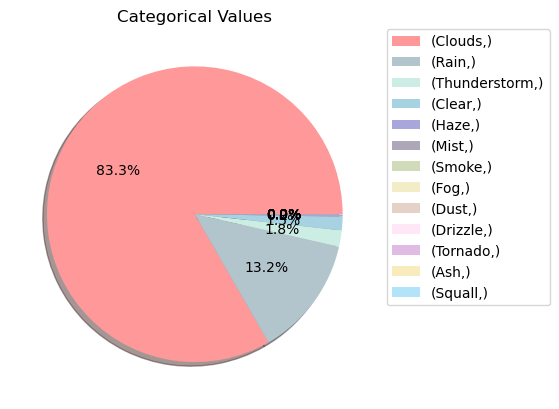

In [11]:
# visualize the distribution of categorical values

colors = ['#ff9999','#B2C4CC','#CCEDE4','#A6D2E1','#A8A6DB', 
            '#ADA7B8', '#D2DBB9', '#F2ECC7', '#E6D1C8', '#FFE7F7',
             '#E0BBE4', '#F8ECBD', '#B3E3F8']
data = df[categorical].value_counts()
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, colors=colors, legend=True, title='Categorical Values', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [12]:
# check the continuous columns

df[continuous].head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_24h,clouds_all
dt_iso,,,,,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,NaN,NaN,98
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,NaN,NaN,91
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,NaN,NaN,94
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,NaN,NaN,94
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,NaN,NaN,76


### Check the statistic and distribution for continous data

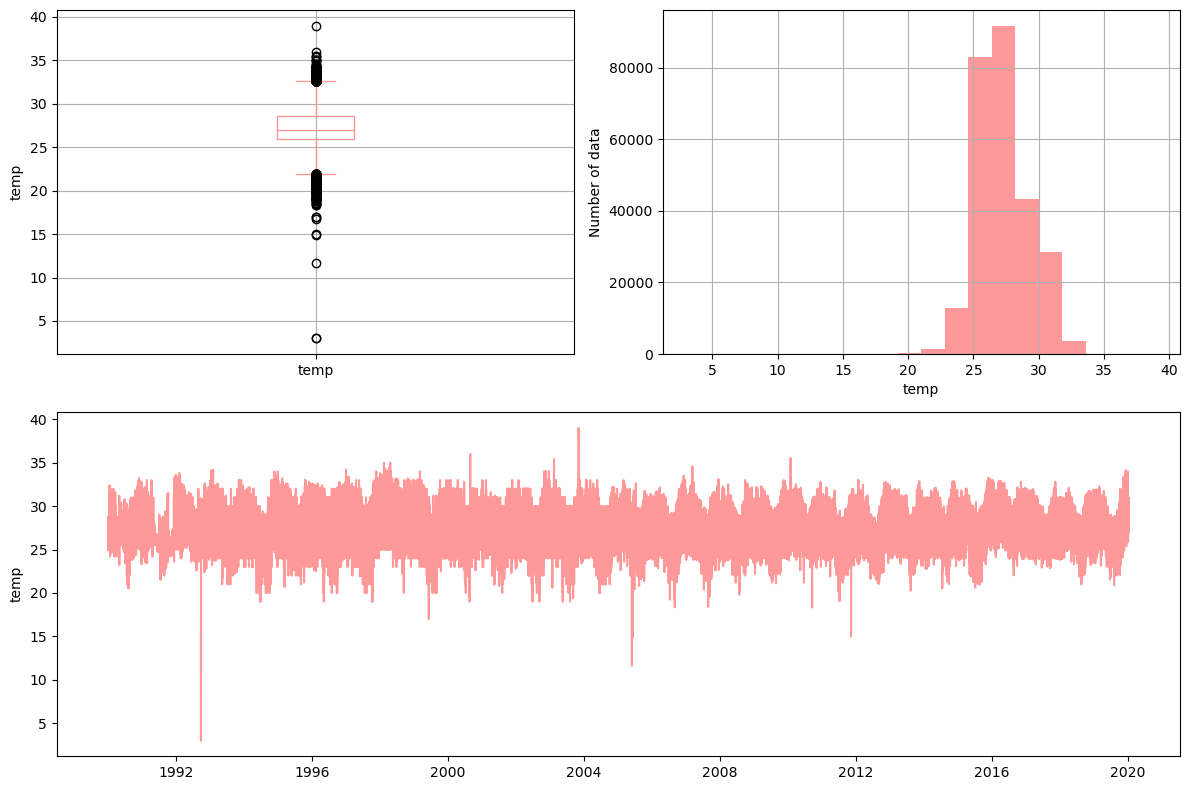

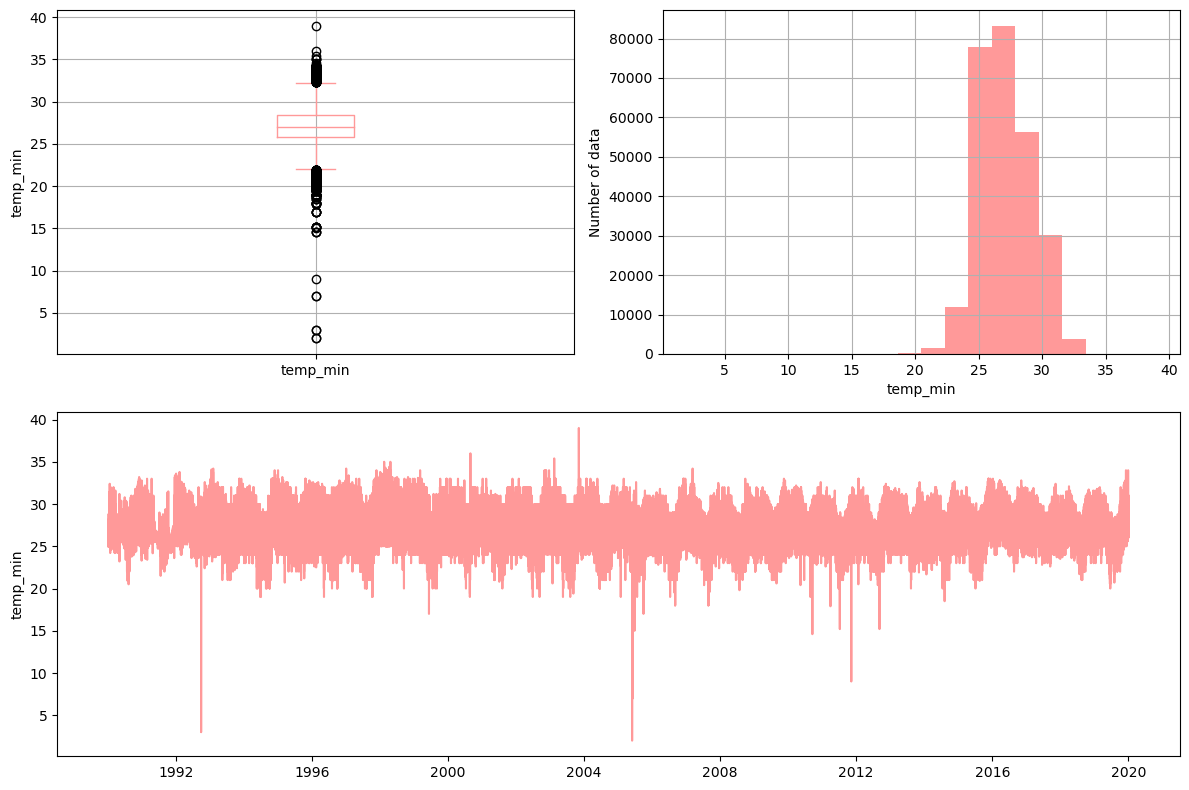

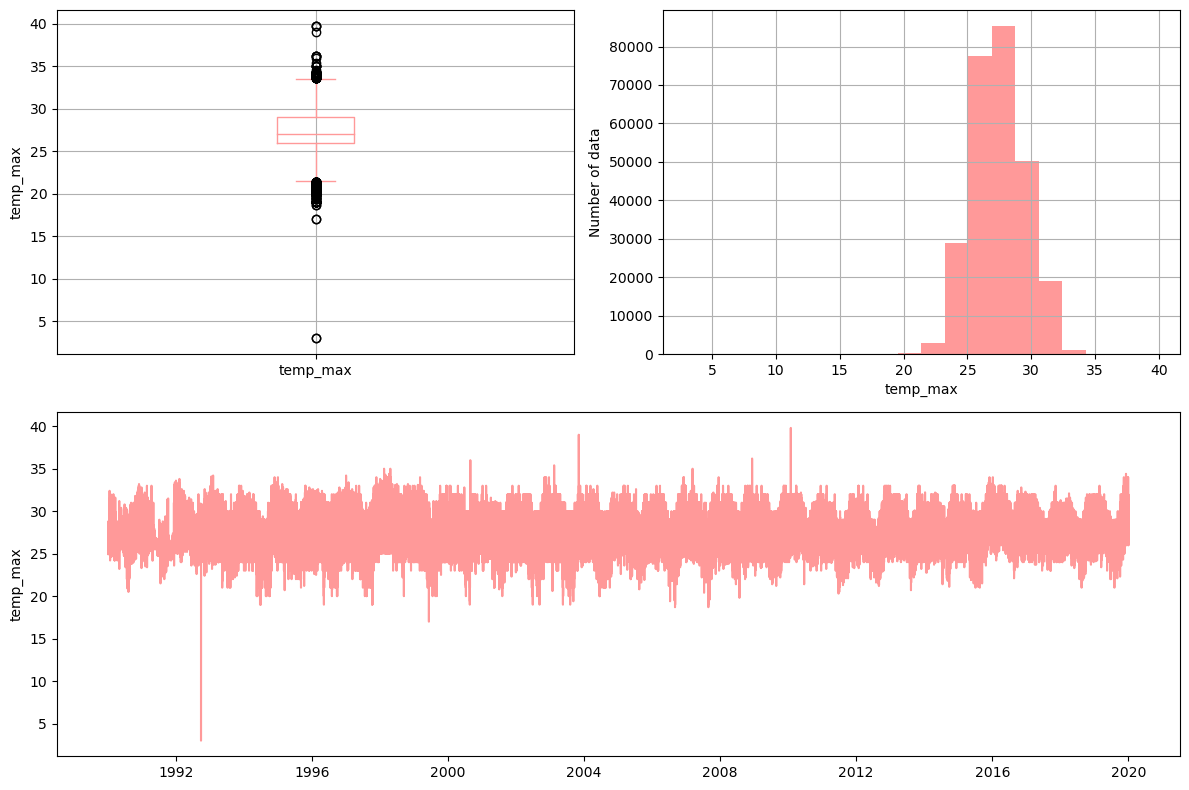

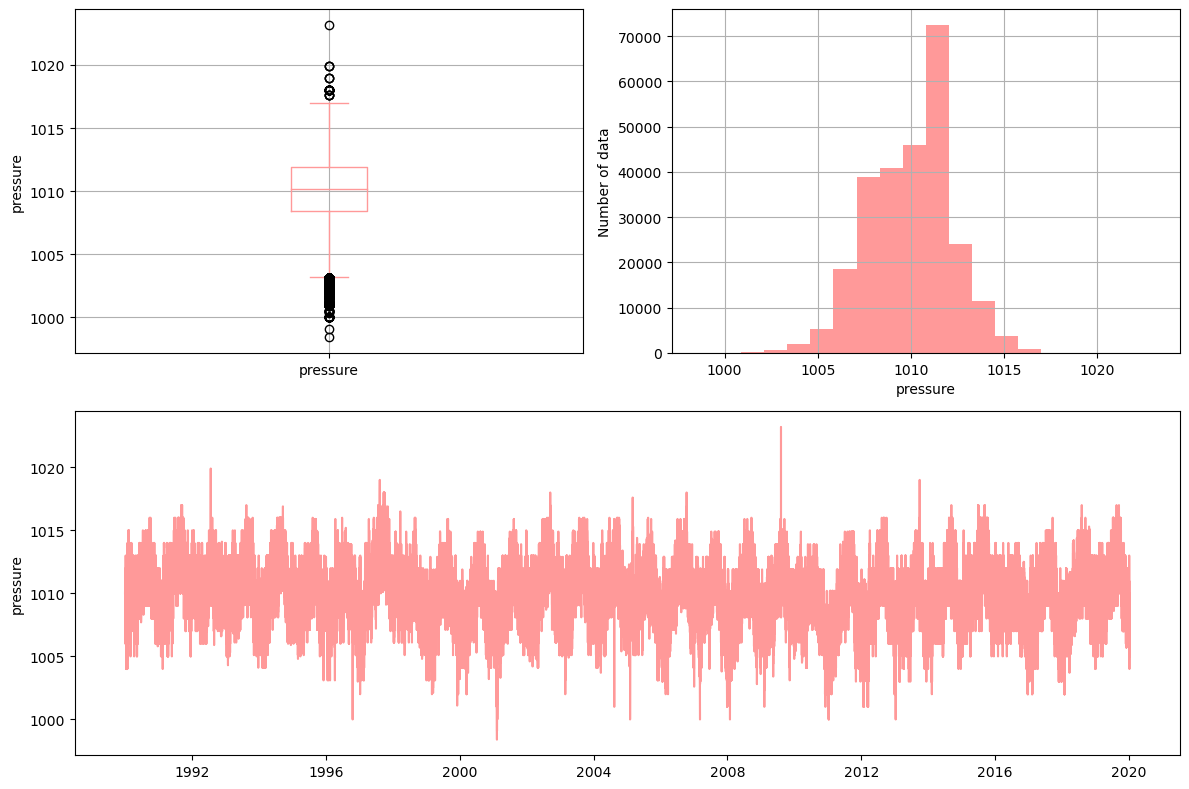

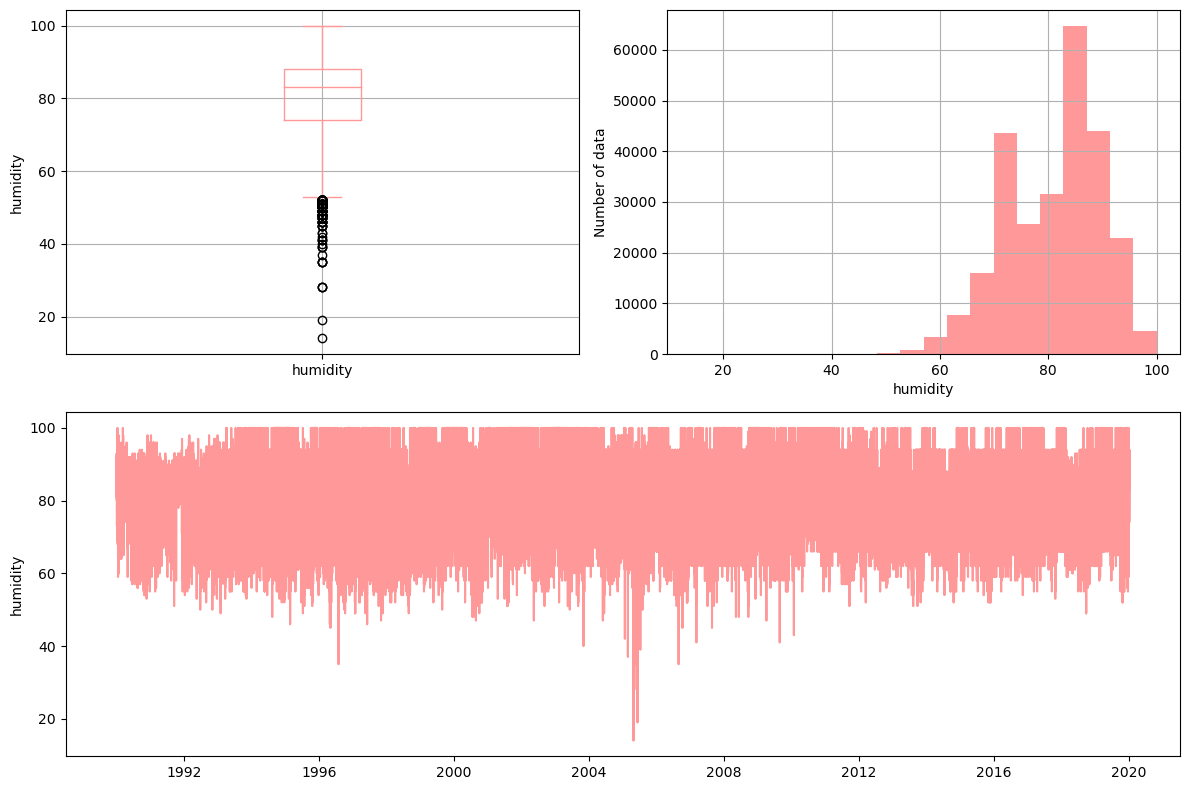

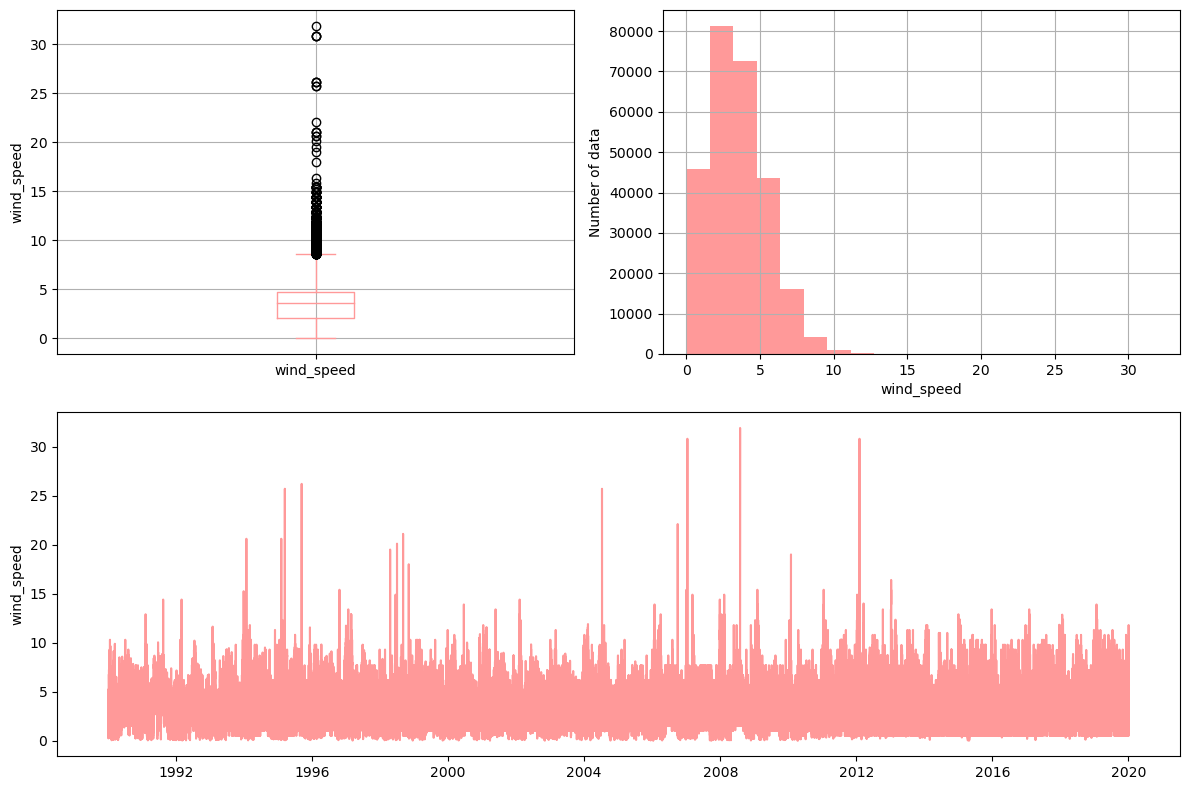

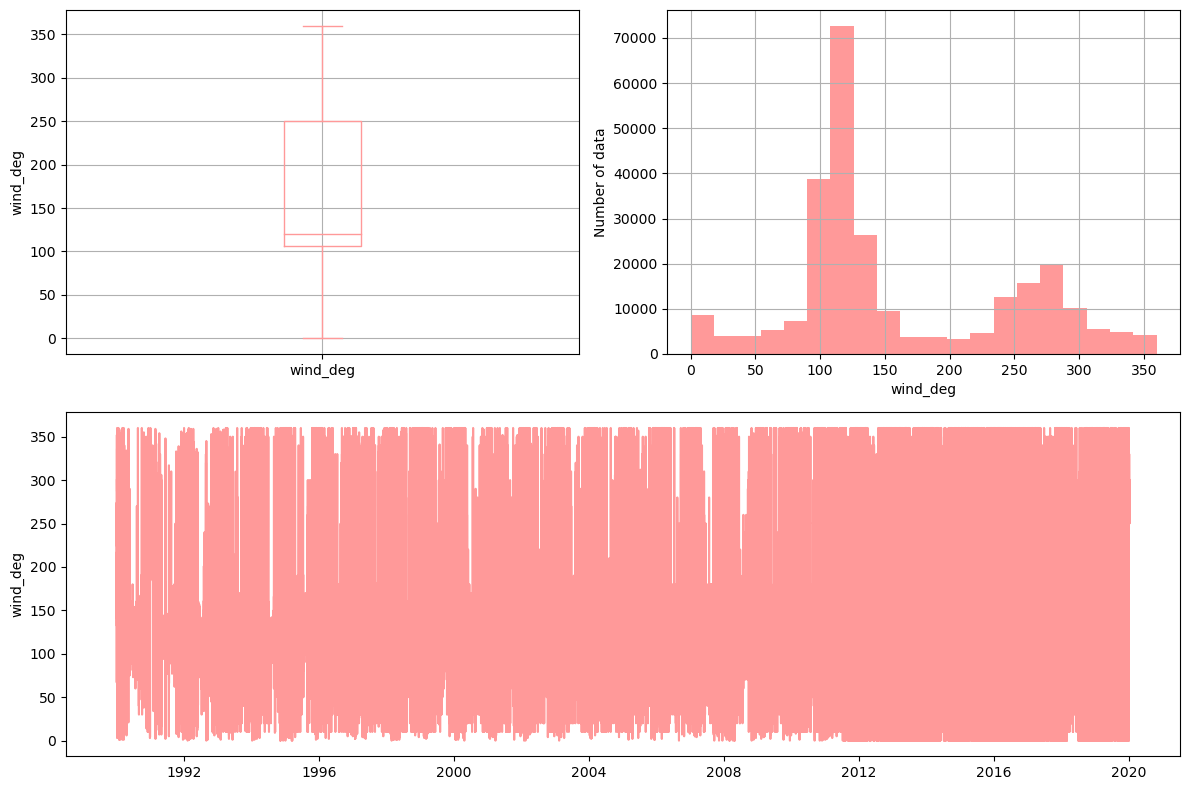

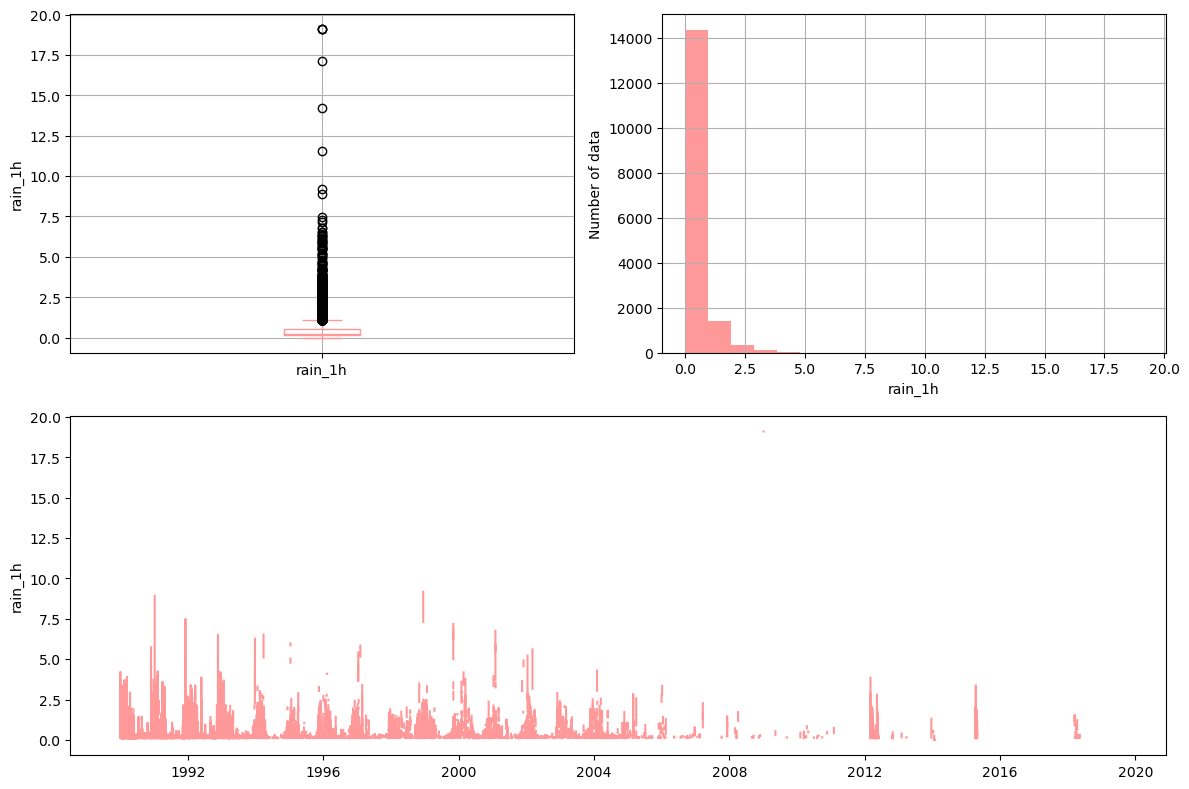

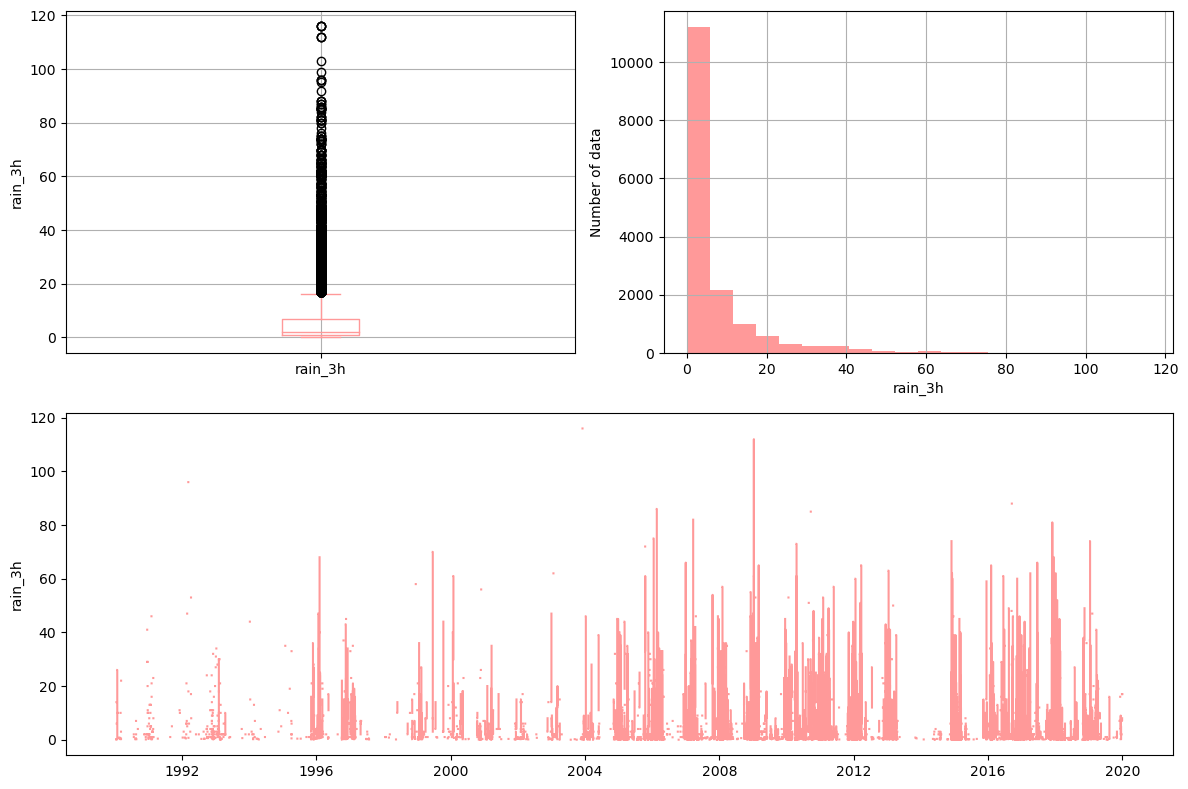

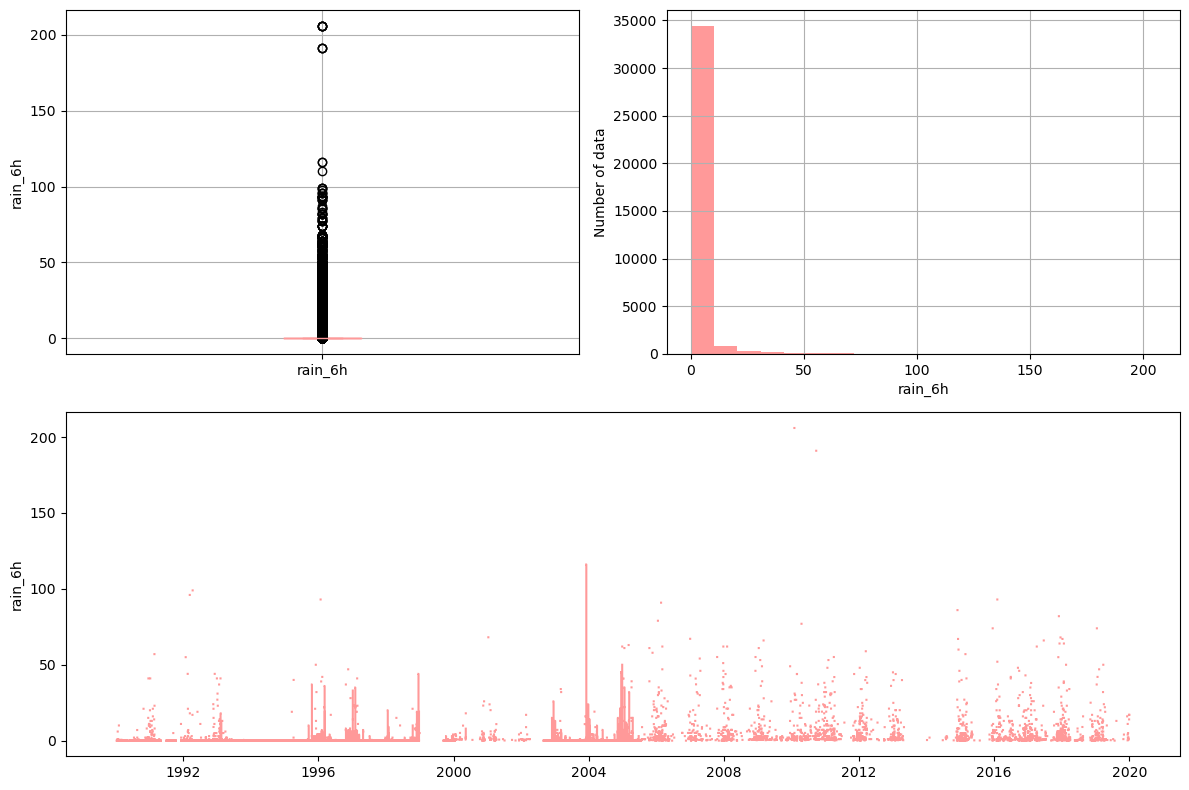

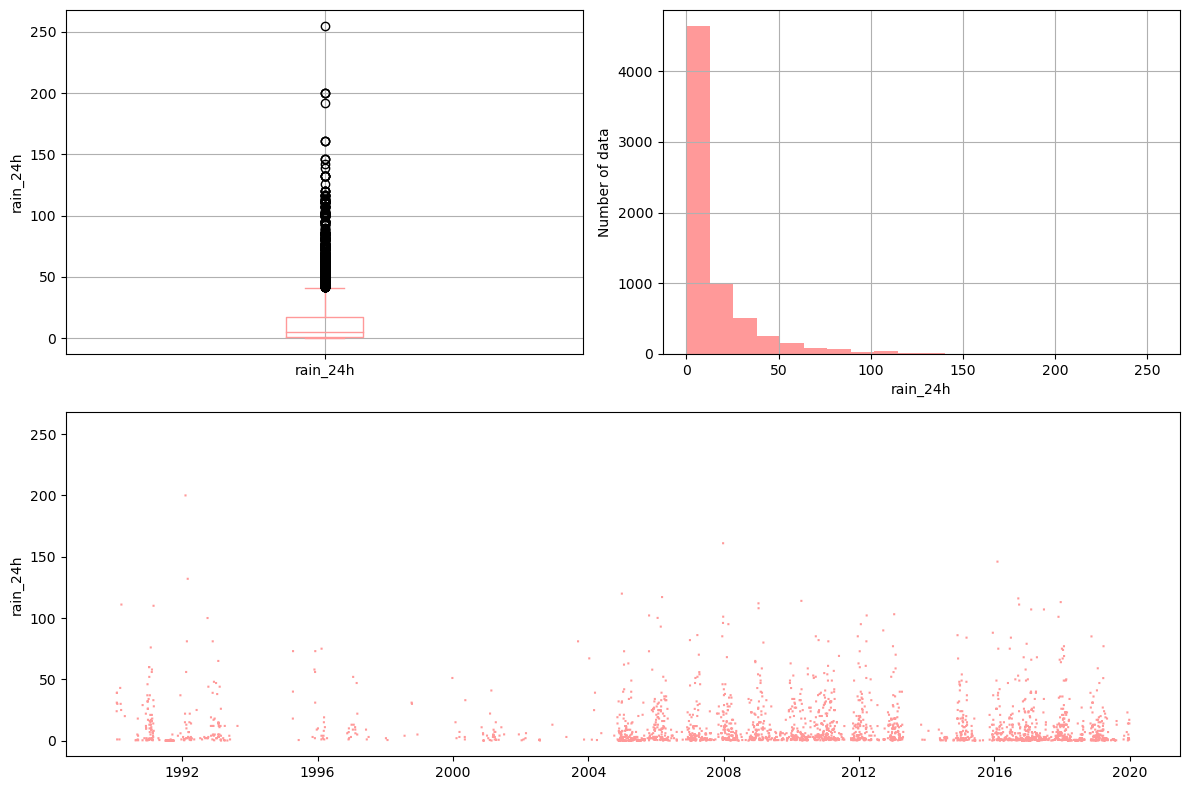

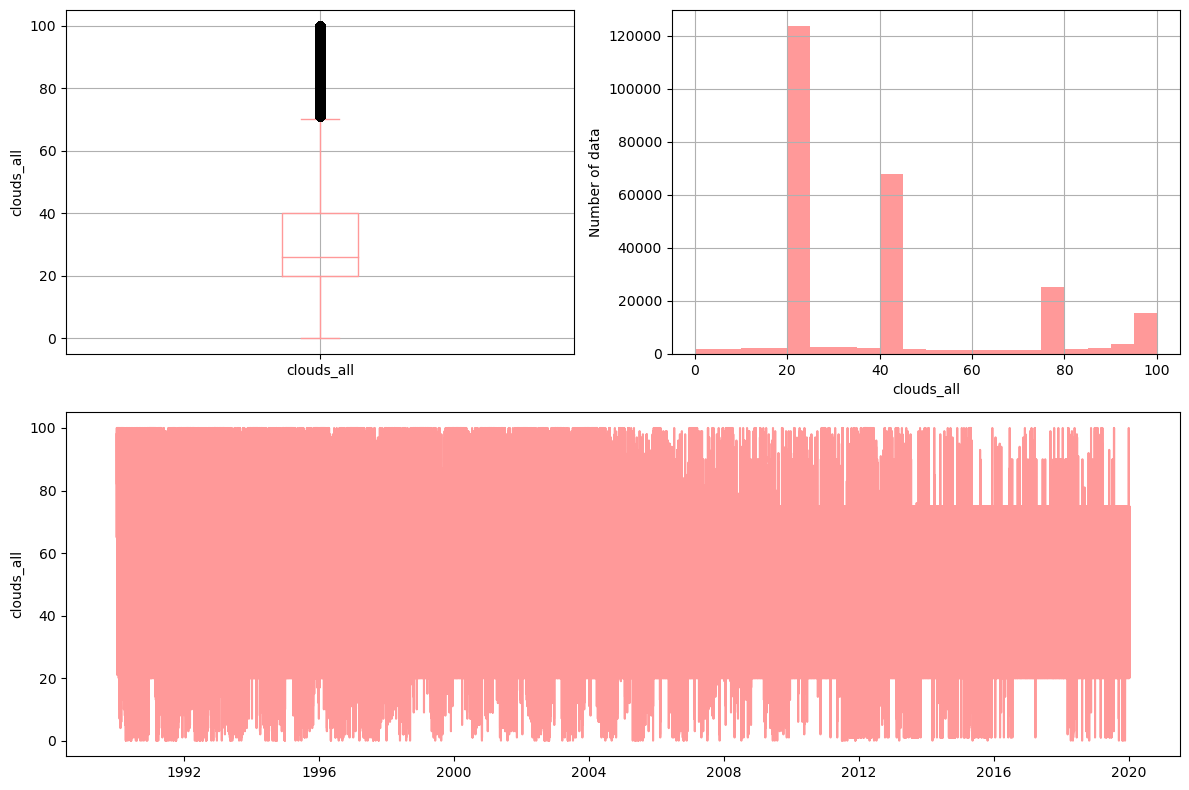

In [12]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1)
    fig = df.boxplot(column=var, color='#ff9999')
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(2, 2, 2)
    fig = df[var].hist(bins=20, color='#ff9999')
    fig.set_ylabel('Number of data')
    fig.set_xlabel(var)

    plt.subplot(2, 1, 2)
    fig = plt.plot(df.index, df[var], color='#ff9999')
    plt.ylabel(var)

    plt.tight_layout ()
    plt.show()

In [13]:
# check missing data

df.isnull().mean()

temp            0.000000
temp_min        0.000000
temp_max        0.000000
pressure        0.000000
humidity        0.000000
wind_speed      0.000000
wind_deg        0.000000
rain_1h         0.938526
rain_3h         0.939016
rain_6h         0.863742
rain_24h        0.974268
clouds_all      0.000000
weather_main    0.000000
dtype: float64

We can see that most null data related to rain number. It is understandable as precipoitation actually discrete variable, yet machine learning do not know it. So for the convinient and sake of the model, I replace the `nan` data to `zero` though I know as meteorologist `zero` have different meaning.  

In [14]:
# replace nan with 0 for rain
df['rain_1h'] = df['rain_1h'].fillna(0)
df['rain_3h'] = df['rain_3h'].fillna(0)
df['rain_6h'] = df['rain_6h'].fillna(0)
df['rain_24h'] = df['rain_24h'].fillna(0)

# check again missing value
df.isnull().mean()

temp            0.0
temp_min        0.0
temp_max        0.0
pressure        0.0
humidity        0.0
wind_speed      0.0
wind_deg        0.0
rain_1h         0.0
rain_3h         0.0
rain_6h         0.0
rain_24h        0.0
clouds_all      0.0
weather_main    0.0
dtype: float64

In [15]:
# reset index
df = df.reset_index()

# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   dt_iso        264924 non-null  datetime64[ns]
 1   temp          264924 non-null  float64       
 2   temp_min      264924 non-null  float64       
 3   temp_max      264924 non-null  float64       
 4   pressure      264924 non-null  float64       
 5   humidity      264924 non-null  int64         
 6   wind_speed    264924 non-null  float64       
 7   wind_deg      264924 non-null  int64         
 8   rain_1h       264924 non-null  float64       
 9   rain_3h       264924 non-null  float64       
 10  rain_6h       264924 non-null  float64       
 11  rain_24h      264924 non-null  float64       
 12  clouds_all    264924 non-null  int64         
 13  weather_main  264924 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 

### Add more feature by breakup the datetime

As weather actually have a seasonality tendency (diurnal, monthly, annual), here I am trying to have several column of year, month, day, and hour. It is also the model cannot have dattime type actually. 

In [16]:
# separate date time into different column and make them as feature
df['yr'] = df['dt_iso'].dt.year
df['mo'] = df['dt_iso'].dt.month
df['day'] = df['dt_iso'].dt.day
df['hr'] = df['dt_iso'].dt.hour

# check the data
df

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_24h,clouds_all,weather_main,yr,mo,day,hr
0,1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,0.0,0.0,0.0,98,Rain,1990,1,1,0
1,1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,0.0,0.0,0.0,91,Rain,1990,1,1,1
2,1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,0.0,0.0,0.0,94,Rain,1990,1,1,2
3,1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,0.0,0.0,0.0,94,Rain,1990,1,1,3
4,1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,0.00,0.0,0.0,0.0,76,Clouds,1990,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,2020-01-07 19:00:00,27.00,27.00,27.00,1007.0,94,4.10,300,0.00,0.0,0.0,0.0,75,Clouds,2020,1,7,19
264920,2020-01-07 20:00:00,27.00,27.00,27.00,1007.0,94,5.70,300,0.00,0.0,0.0,0.0,75,Clouds,2020,1,7,20
264921,2020-01-07 21:00:00,28.00,28.00,28.00,1007.0,83,6.70,290,0.00,0.0,0.0,0.0,75,Clouds,2020,1,7,21
264922,2020-01-07 22:00:00,28.00,28.00,28.00,1007.0,83,6.20,290,0.00,0.0,0.0,0.0,40,Clouds,2020,1,7,22


In [17]:
# drop dt_iso
df = df.drop(['dt_iso'], axis=1)

# see the latest version of df
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   temp          264924 non-null  float64
 1   temp_min      264924 non-null  float64
 2   temp_max      264924 non-null  float64
 3   pressure      264924 non-null  float64
 4   humidity      264924 non-null  int64  
 5   wind_speed    264924 non-null  float64
 6   wind_deg      264924 non-null  int64  
 7   rain_1h       264924 non-null  float64
 8   rain_3h       264924 non-null  float64
 9   rain_6h       264924 non-null  float64
 10  rain_24h      264924 non-null  float64
 11  clouds_all    264924 non-null  int64  
 12  weather_main  264924 non-null  object 
 13  yr            264924 non-null  int64  
 14  mo            264924 non-null  int64  
 15  day           264924 non-null  int64  
 16  hr            264924 non-null  int64  
dtypes: float64(9), int64(7), object(1)
memory usage:

## Fit the model with raw feature variables

### Try with Gradient Boost Model Classifier (GBMClassifier)

This model is chosen as it can work without label encoding and also do not really matter to variables distribution and outliers. 

In [18]:
# for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [20]:
# test without label encoder 

# import module
from sklearn.model_selection import train_test_split

# separate into training and testing set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    df.drop(['weather_main'], axis=1),  # predictors
    df['weather_main'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train_c.shape, X_test_c.shape, y_train_c.shape, y_test_c.shape

((211939, 16), (52985, 16), (211939,), (52985,))

In [21]:
# test train data without labelling

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf_c = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf_c.fit(X_train_c, y_train_c)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf_c.score(X_train_c, y_train_c)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf_c.score(X_test_c, y_test_c)))

Learning rate:  0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.876
Learning rate:  0.075
Accuracy score (training): 0.926
Accuracy score (validation): 0.925
Learning rate:  0.1
Accuracy score (training): 0.005
Accuracy score (validation): 0.005
Learning rate:  0.25
Accuracy score (training): 0.939
Accuracy score (validation): 0.939
Learning rate:  0.5
Accuracy score (training): 0.259
Accuracy score (validation): 0.258
Learning rate:  0.75
Accuracy score (training): 0.029
Accuracy score (validation): 0.029
Learning rate:  1
Accuracy score (training): 0.000
Accuracy score (validation): 0.000


In [21]:
# import module 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# use the best learning rate without labelencoding
gb_clf2_c = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gb_clf2_c.fit(X_train_c, y_train_c)
predictions_c = gb_clf2_c.predict(X_test_c)

print("Confusion Matrix:")
print(confusion_matrix(y_test_c, predictions_c))

print("Classification Report")
print(classification_report(y_test_c, predictions_c))

Confusion Matrix:
[[  793     0     1     0     0     2     0     0     0     0     0]
 [    0 43310   712     0     0     8     0    37     0     1     0]
 [    0     2     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0]
 [    0     3     0     0     0     0     0     1     0     0     0]
 [    2    93     5     0     0     4     0     1     0     0     0]
 [    0    14     0     0     0     0     0     1     0     0     0]
 [    3  1222   123     0     0     2     0  5663     0    69     0]
 [    1     6     0     0     0     0     0     0     0     0     0]
 [    0   605    18     0     0     0     0   273     0     5     0]
 [    0     3     0     0     0     0     0     0     0     0     0]]
Classification Report


/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Clear       0.99      1.00      0.99       796
      Clouds       0.96      0.98      0.97     44068
     Drizzle       0.00      0.00      0.00         2
        Dust       0.00      0.00      0.00         2
         Fog       0.00      0.00      0.00         4
        Haze       0.25      0.04      0.07       105
        Mist       0.00      0.00      0.00        15
        Rain       0.95      0.80      0.87      7082
       Smoke       0.00      0.00      0.00         7
Thunderstorm       0.07      0.01      0.01       901
     Tornado       0.00      0.00      0.00         3

    accuracy                           0.94     52985
   macro avg       0.29      0.26      0.26     52985
weighted avg       0.94      0.94      0.94     52985



/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# perform a feature importance for multipass permutation for model without labelencoding

from sklearn.inspection import permutation_importance

r_c = permutation_importance(gb_clf2_c, X_test_c, y_test_c, n_repeats=50,random_state=0)
print('top feature importance for target without labelencoding')
for i in r_c.importances_mean.argsort()[::-1]:
    if r_c.importances_mean[i] - 2 * r_c.importances_std[i] > 0:
        print(f"{X_test_c.columns[i]:<8}"
        f"{r_c.importances_mean[i]:.3f}"
        f" +/- {r_c.importances_std[i]:.3f}")

top feature importance for target without labelencoding
rain_1h 0.099 +/- 0.001
rain_3h 0.071 +/- 0.001
clouds_all0.029 +/- 0.000
temp    0.009 +/- 0.000
mo      0.006 +/- 0.000
wind_speed0.003 +/- 0.000
hr      0.003 +/- 0.000
temp_max0.002 +/- 0.000
pressure0.002 +/- 0.000
wind_deg0.001 +/- 0.000
rain_6h 0.001 +/- 0.000
humidity0.001 +/- 0.000
rain_24h0.000 +/- 0.000


Text(0, 0.5, 'Mean Decrease in Impurity')

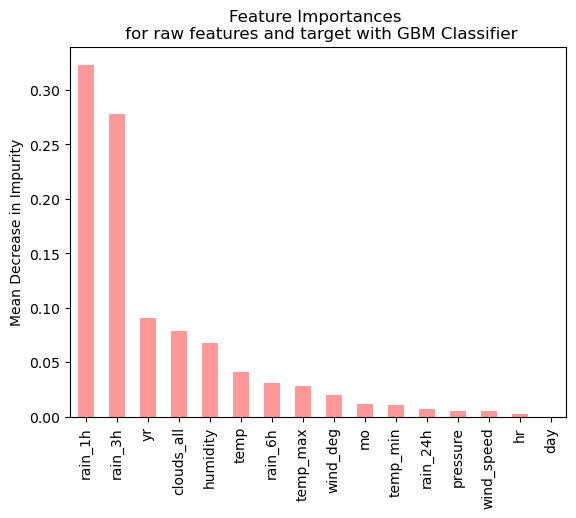

In [22]:
# visualize the feature importance

ftr_imp = pd.Series(gb_clf2_c.feature_importances_, index=X_train_c.columns).sort_values(ascending=False)
ftr_imp.plot(kind='bar', color='#ff9999', title='Feature Importances \n for raw features and target with GBM Classifier')
plt.ylabel('Mean Decrease in Impurity')

As we can see that the top-3 feature important actually belong to certain weather categories. It means there is strong dependent between those features and the target. We may drop them to see how model actually learn the data that really has no direct influence with target. 

#### Try drop features that has direct relationship with target (GBMClassifier)

In [23]:
# separate into training and testing set
X_train_cr, X_test_cr, y_train_cr, y_test_cr = train_test_split(
    df.drop(['weather_main', 'rain_1h', 'rain_3h', 'rain_6h', 'rain_24h', 'clouds_all'], axis=1),  # predictors
    df['weather_main'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train_cr.shape, X_test_cr.shape, y_train_cr.shape, y_test_cr.shape

((211939, 11), (52985, 11), (211939,), (52985,))

In [26]:
# test train data without labelling and selected features

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf_cr = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf_cr.fit(X_train_cr, y_train_cr)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf_cr.score(X_train_cr, y_train_cr)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf_cr.score(X_test_cr, y_test_cr)))

Learning rate:  0.05
Accuracy score (training): 0.833
Accuracy score (validation): 0.831
Learning rate:  0.075
Accuracy score (training): 0.841
Accuracy score (validation): 0.839
Learning rate:  0.1
Accuracy score (training): 0.844
Accuracy score (validation): 0.842
Learning rate:  0.25
Accuracy score (training): 0.847
Accuracy score (validation): 0.844
Learning rate:  0.5
Accuracy score (training): 0.002
Accuracy score (validation): 0.002
Learning rate:  0.75
Accuracy score (training): 0.002
Accuracy score (validation): 0.003
Learning rate:  1
Accuracy score (training): 0.087
Accuracy score (validation): 0.087


In [24]:
# use the best learning rate without labelencoding
gb_clf2_cr = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gb_clf2_cr.fit(X_train_cr, y_train_cr)
predictions_cr = gb_clf2_cr.predict(X_test_cr)

print("Confusion Matrix:")
print(confusion_matrix(y_test_cr, predictions_cr))

print("Classification Report")
print(classification_report(y_test_cr, predictions_cr))

Confusion Matrix:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    6     0   782     0     0     0     0     0     8     0     0     0
      0]
 [  340     0 42934     0     0     0     1     0   784     0     9     0
      0]
 [    0     0     2     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     2     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     4     0     0     0     0     0     0     0     0     0
      0]
 [    0     0   105     0     0     0     0     0     0     0     0     0
      0]
 [    0     0    15     0     0     0     0     0     0     0     0     0
      0]
 [   91     0  5193     0     0     0     0     0  1797     0     1     0
      0]
 [    0     0     7     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   15     0   736     0     0     0     0     0   150     0     0  

/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Us

              precision    recall  f1-score   support

         Ash       0.00      0.00      0.00         0
       Clear       0.00      0.00      0.00       796
      Clouds       0.86      0.97      0.91     44068
     Drizzle       0.00      0.00      0.00         2
        Dust       0.00      0.00      0.00         2
         Fog       0.00      0.00      0.00         4
        Haze       0.00      0.00      0.00       105
        Mist       0.00      0.00      0.00        15
        Rain       0.66      0.25      0.37      7082
       Smoke       0.00      0.00      0.00         7
      Squall       0.00      0.00      0.00         0
Thunderstorm       0.00      0.00      0.00       901
     Tornado       0.00      0.00      0.00         3

    accuracy                           0.84     52985
   macro avg       0.12      0.09      0.10     52985
weighted avg       0.80      0.84      0.81     52985



/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# import module 
from sklearn.inspection import permutation_importance

# perform a feature importance for multipass permutation for model without labelencoding
r_cr = permutation_importance(gb_clf2_cr, X_test_cr, y_test_cr, n_repeats=50,random_state=0)
print('top feature importance for target without labelencoding but drop some features')
for i in r_cr.importances_mean.argsort()[::-1]:
    if r_cr.importances_mean[i] - 2 * r_cr.importances_std[i] > 0:
        print(f"{X_test_cr.columns[i]:<8}"
        f"{r_cr.importances_mean[i]:.3f}"
        f" +/- {r_cr.importances_std[i]:.3f}")

top feature importance for target without labelencoding but drop some features
mo      0.021 +/- 0.001
wind_deg0.012 +/- 0.001
humidity0.011 +/- 0.001
temp_max0.010 +/- 0.000
hr      0.007 +/- 0.000
wind_speed0.005 +/- 0.000
temp_min0.004 +/- 0.000
yr      0.003 +/- 0.000
day     0.002 +/- 0.000
temp    0.002 +/- 0.000


Text(0, 0.5, 'Mean Decrease in Impurity')

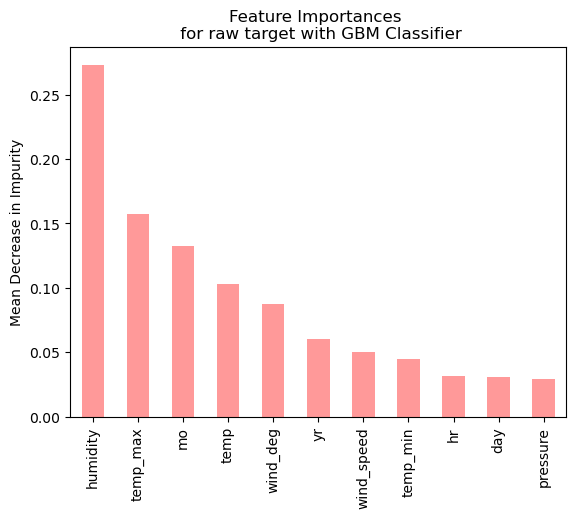

In [27]:
# visualize the feature importance

ftr_imp_cr = pd.Series(gb_clf2_cr.feature_importances_, index=X_train_cr.columns).sort_values(ascending=False)
ftr_imp_cr.plot(kind='bar', color='#ff9999',  title='Feature Importances \n for raw target with GBM Classifier')
plt.ylabel('Mean Decrease in Impurity')

## Apply Feature Engineer For Target

### Apply label-encoder

In [28]:
# import module
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# assigning numerical values and storing in another column
df['weather_main_cat'] = labelencoder.fit_transform(df['weather_main'])

In [29]:
# check the assign labelencoder

print(df.weather_main.unique())
print()
print(df.weather_main_cat.unique())

['Rain' 'Clouds' 'Thunderstorm' 'Clear' 'Haze' 'Dust' 'Fog' 'Mist'
 'Squall' 'Tornado' 'Smoke' 'Drizzle' 'Ash']

[ 8  2 11  1  6  4  5  7 10 12  9  3  0]


### Check the correlation among variables in the data

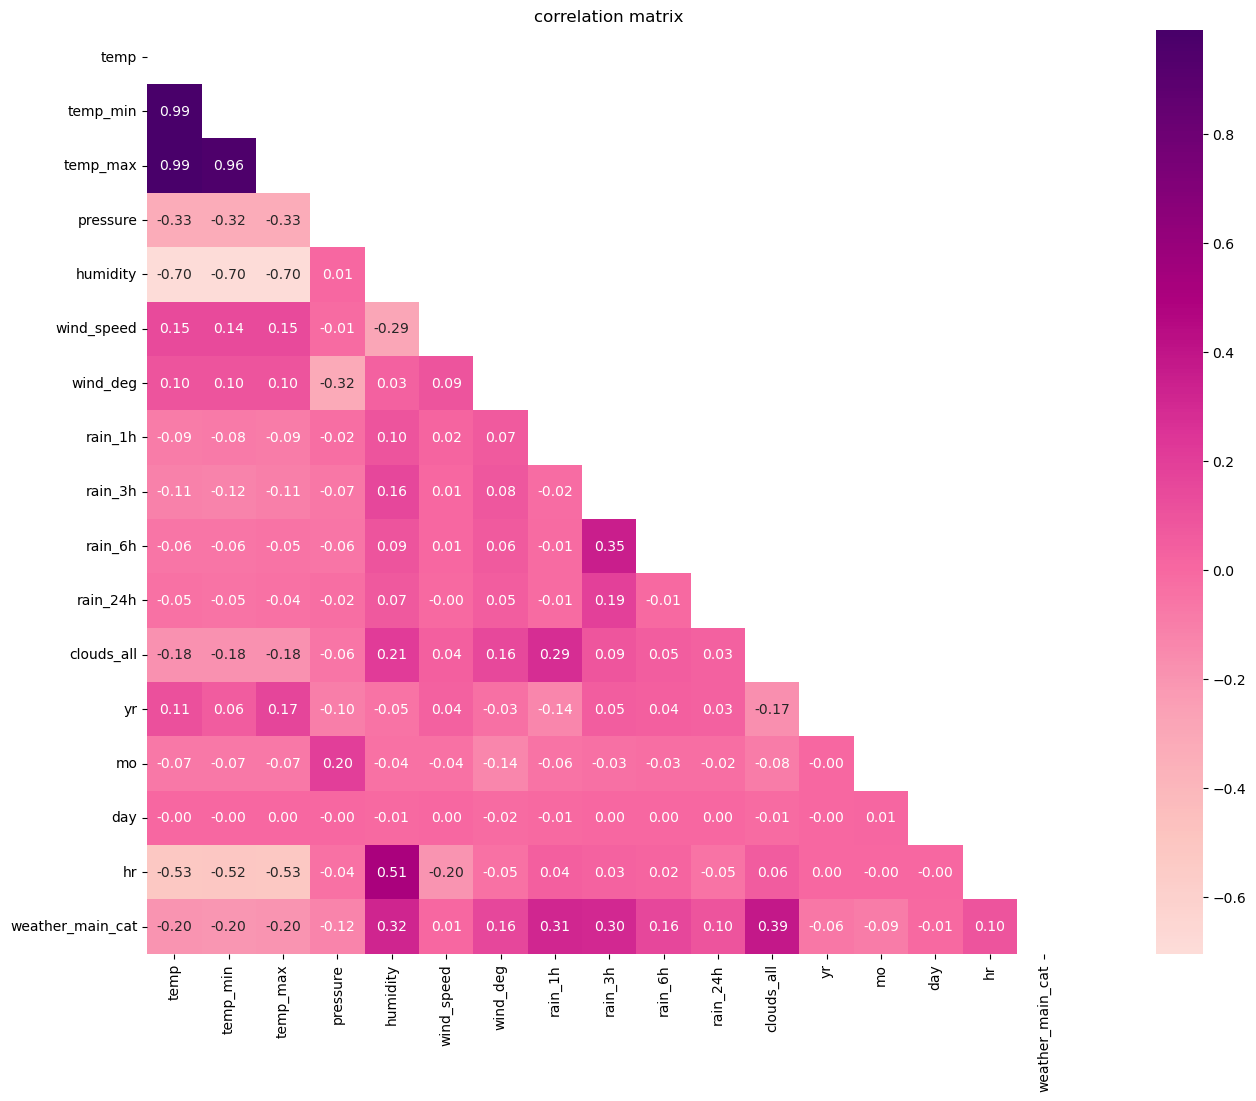

In [30]:
import seaborn as sns

matrix = df.corr()
mask = np.triu(np.ones_like(matrix,dtype='bool'))

plt.figure(figsize=(22,12))
sns.heatmap(matrix,mask=mask,annot=True,center=0,fmt='.2f',square=True,cmap="RdPu").set(title="correlation matrix")
plt.show()

### Drop variables containing related variables to target 

In [31]:
# drop variables 
df = df.drop(['rain_1h', 'rain_3h', 'rain_6h', 'rain_24h', 'clouds_all', 'weather_main'], axis=1)

# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp              264924 non-null  float64
 1   temp_min          264924 non-null  float64
 2   temp_max          264924 non-null  float64
 3   pressure          264924 non-null  float64
 4   humidity          264924 non-null  int64  
 5   wind_speed        264924 non-null  float64
 6   wind_deg          264924 non-null  int64  
 7   yr                264924 non-null  int64  
 8   mo                264924 non-null  int64  
 9   day               264924 non-null  int64  
 10  hr                264924 non-null  int64  
 11  weather_main_cat  264924 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 24.3 MB


#### Apply feature engineer One-Hot-Encode for month

I have tried to build a model of GBM Classifier with or without labeling, yet everything is same. So here I will skip them and try to apply one-hot-encoder as from permutation impurtance (use feature that has no direct values with target) of GBM Classifier model without labelling, `month` has highest contribution, yet it is an ordinal number. 

In [32]:
# import module to apply future engineering by one-hot encoding
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['mo']]).toarray())

#merge one-hot encoded columns back with original DataFrame
df_ohe = df.join(encoder_df)

#view final df
df_ohe

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,yr,mo,day,...,2,3,4,5,6,7,8,9,10,11
0,25.82,25.82,25.82,1010.0,86,1.36,225,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26.20,26.20,26.20,1011.0,84,2.09,247,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.45,26.45,26.45,1011.0,84,2.44,262,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26.80,26.80,26.80,1011.0,82,2.29,271,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.04,27.04,27.04,1010.0,82,1.71,274,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,27.00,27.00,27.00,1007.0,94,4.10,300,2020,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264920,27.00,27.00,27.00,1007.0,94,5.70,300,2020,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264921,28.00,28.00,28.00,1007.0,83,6.70,290,2020,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264922,28.00,28.00,28.00,1007.0,83,6.20,290,2020,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# drop original mounth column 
df_ohe = df_ohe.drop(['mo'], axis=1)

In [34]:
#rename columns
df_ohe.columns = ['temp','temp_min','temp_max','pressure','humidity','wind_speed',
                    'wind_deg', 'yr', 'day', 'hr', 'weather_main_cat',
                    'jan','feb','mar','apr','may','jun','jul','aug','sep',
                    'oct','nov','dec']

#view final df
df_ohe

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,yr,day,hr,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,25.82,25.82,25.82,1010.0,86,1.36,225,1990,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26.20,26.20,26.20,1011.0,84,2.09,247,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.45,26.45,26.45,1011.0,84,2.44,262,1990,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26.80,26.80,26.80,1011.0,82,2.29,271,1990,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.04,27.04,27.04,1010.0,82,1.71,274,1990,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,27.00,27.00,27.00,1007.0,94,4.10,300,2020,7,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264920,27.00,27.00,27.00,1007.0,94,5.70,300,2020,7,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264921,28.00,28.00,28.00,1007.0,83,6.70,290,2020,7,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264922,28.00,28.00,28.00,1007.0,83,6.20,290,2020,7,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build Machine Learning Model 

In this segment I am tryin to build model based tree decision to see which one is perform best, yet due to the memory limitation, I did not attempt to tune hyperparamter, except for GBM I did a little play with `learning-rate`.

In [35]:
# import module 
from sklearn.model_selection import train_test_split

# separate into training and testing set
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    df_ohe.drop(['weather_main_cat'], axis=1),  # predictors
    df_ohe['weather_main_cat'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train_ohe.shape, X_test_ohe.shape, y_train_ohe.shape, y_test_ohe.shape

((211939, 22), (52985, 22), (211939,), (52985,))

### 1. Gradient Boost Model (GBM Classifier)

In [36]:
# import module
from sklearn.ensemble import GradientBoostingClassifier

# do same procedure from previous part, but now for final feature
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf_ohe = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf_ohe.fit(X_train_ohe, y_train_ohe)

    print("Learning rate OHE: ", learning_rate)
    print("Accuracy score (training) OHE: {0:.3f}".format(gb_clf_ohe.score(X_train_ohe, y_train_ohe)))
    print("Accuracy score (validation) OHE: {0:.3f}".format(gb_clf_ohe.score(X_test_ohe, y_test_ohe)))

Learning rate OHE:  0.05
Accuracy score (training) OHE: 0.833
Accuracy score (validation) OHE: 0.831
Learning rate OHE:  0.075
Accuracy score (training) OHE: 0.834
Accuracy score (validation) OHE: 0.833
Learning rate OHE:  0.1
Accuracy score (training) OHE: 0.838
Accuracy score (validation) OHE: 0.837
Learning rate OHE:  0.25
Accuracy score (training) OHE: 0.848
Accuracy score (validation) OHE: 0.846
Learning rate OHE:  0.5
Accuracy score (training) OHE: 0.649
Accuracy score (validation) OHE: 0.647
Learning rate OHE:  0.75
Accuracy score (training) OHE: 0.017
Accuracy score (validation) OHE: 0.017
Learning rate OHE:  1
Accuracy score (training) OHE: 0.254
Accuracy score (validation) OHE: 0.252


In [37]:
# import module
from sklearn.metrics import classification_report, confusion_matrix

# use the best learning rate 
gb_clf2_ohe = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gb_clf2_ohe.fit(X_train_ohe, y_train_ohe)
predictions_ohe = gb_clf2_ohe.predict(X_test_ohe)

print("Confusion Matrix:")
print(confusion_matrix(y_test_ohe, predictions_ohe))

print("Classification Report")
print(classification_report(y_test_ohe, predictions_ohe))

Confusion Matrix:
[[    0   786     0     0     0     0     0    10     0     0     0]
 [    2 43194     0    13    26     5     0   828     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0]
 [    0     4     0     0     0     0     0     0     0     0     0]
 [    0   101     0     0     0     2     0     2     0     0     0]
 [    0    15     0     0     0     0     0     0     0     0     0]
 [    0  5446     0    15     8     0     0  1613     0     0     0]
 [    0     7     0     0     0     0     0     0     0     0     0]
 [    0   759     0     0     1     0     0   141     0     0     0]
 [    0     3     0     0     0     0     0     0     0     0     0]]
Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       796
           2       0.86      0.98      0.92     44068
           3       0.00      0.00    

/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Text(0, 0.5, 'Mean Decrease in Impurity')

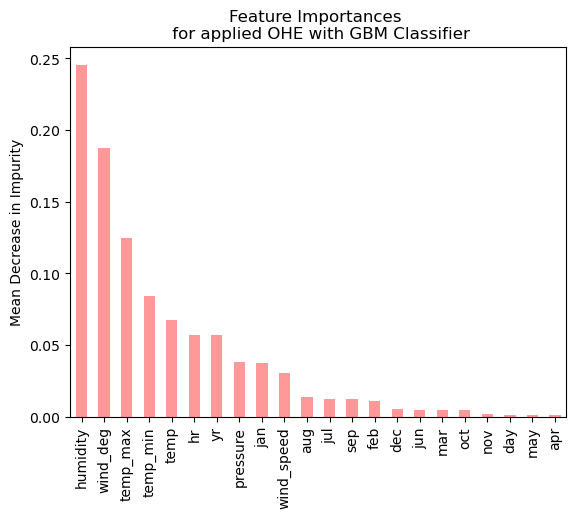

In [38]:
# visualize the feature importance

feature_importances = pd.Series(gb_clf2_ohe.feature_importances_, index=X_train_ohe.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', color='#ff9999', title='Feature Importances \n for applied OHE with GBM Classifier')

plt.ylabel('Mean Decrease in Impurity')

In [39]:
# import module
from sklearn.inspection import permutation_importance

# perform a feature importance for multipass permutation 
r_ohe = permutation_importance(gb_clf2_ohe , X_test_ohe , y_test_ohe , n_repeats=50,random_state=0)
print('top feature importance for the applied OHE with GBM classifier')
for i in r_ohe .importances_mean.argsort()[::-1]:
    if r_ohe .importances_mean[i] - 2 * r_ohe .importances_std[i] > 0:
        print(f"{X_test_ohe .columns[i]:<8}"
        f"{r_ohe .importances_mean[i]:.3f}"
        f" +/- {r_ohe .importances_std[i]:.3f}")

top feature importance for the applied OHE with GBM classifier
humidity0.009 +/- 0.000
wind_deg0.007 +/- 0.000
temp_max0.005 +/- 0.000
temp_min0.004 +/- 0.000
hr      0.003 +/- 0.000
temp    0.002 +/- 0.000
wind_speed0.002 +/- 0.000
yr      0.002 +/- 0.000
feb     0.001 +/- 0.000
jan     0.001 +/- 0.000
aug     0.001 +/- 0.000
dec     0.001 +/- 0.000
oct     0.000 +/- 0.000


### 2. XGradient Boost Model (XGBoost Classifier)

In [40]:
# import module
from xgboost import XGBClassifier

# fit model 
xgb_clf_ohe = XGBClassifier()
xgb_clf_ohe.fit(X_train_ohe, y_train_ohe)

# see the score
score_ohe = xgb_clf_ohe.score(X_test_ohe, y_test_ohe)
print("Accuracy for applied OHE with XGB Classifier:", (round(score_ohe, 2)))

Accuracy for applied OHE with XGB Classifier: 0.88


Text(0, 0.5, 'Mean Decrease in Impurity')

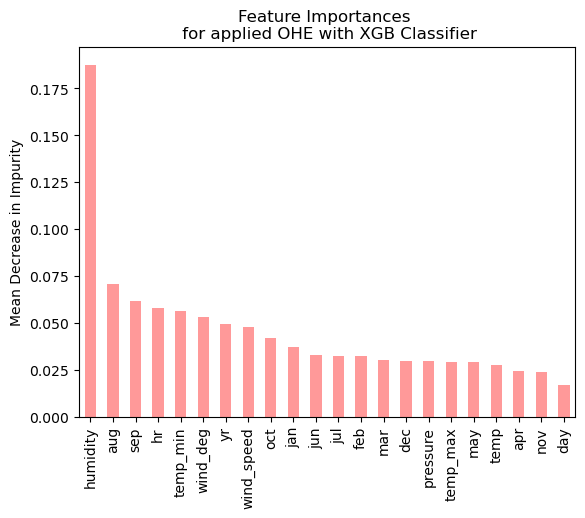

In [41]:
# visualize the feature importance for plain data

feature_importances = pd.Series(xgb_clf_ohe.feature_importances_, index=X_train_ohe.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', color='#ff9999', title='Feature Importances \n for applied OHE with XGB Classifier')
plt.ylabel('Mean Decrease in Impurity')

In [30]:
# see the multipass permutation importance for XGB Classifier

r_xgb_ohe = permutation_importance(xgb_clf_ohe, X_test_ohe, y_test_ohe, n_repeats=50,random_state=0)

print('top feature importance for OHE with XGB Classifier:')
for i in r_xgb_ohe.importances_mean.argsort()[::-1]:
    if r_xgb_ohe.importances_mean[i] - 2 * r_xgb_ohe.importances_std[i] > 0:
        print(f"{X_test_ohe.columns[i]:<8}"
        f"{r_xgb_ohe.importances_mean[i]:.3f}"
        f" +/- {r_xgb_ohe.importances_std[i]:.3f}")

top feature importance for OHE with XGB Classifier:
hr      0.040 +/- 0.001
humidity0.035 +/- 0.001
temp_min0.026 +/- 0.001
wind_speed0.021 +/- 0.001
yr      0.015 +/- 0.001
wind_deg0.014 +/- 0.001
temp    0.007 +/- 0.001
pressure0.007 +/- 0.001
temp_max0.007 +/- 0.001
oct     0.004 +/- 0.000
aug     0.003 +/- 0.000
sep     0.003 +/- 0.000
day     0.003 +/- 0.000
jul     0.002 +/- 0.000
jun     0.001 +/- 0.000
nov     0.001 +/- 0.000
jan     0.001 +/- 0.000
may     0.001 +/- 0.000
mar     0.001 +/- 0.000
apr     0.001 +/- 0.000
dec     0.000 +/- 0.000


#### Try to compare with SHAP feature to see the most important feature

In [42]:
# import module for shap

import seaborn as sns
import shap # v0.41.0
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


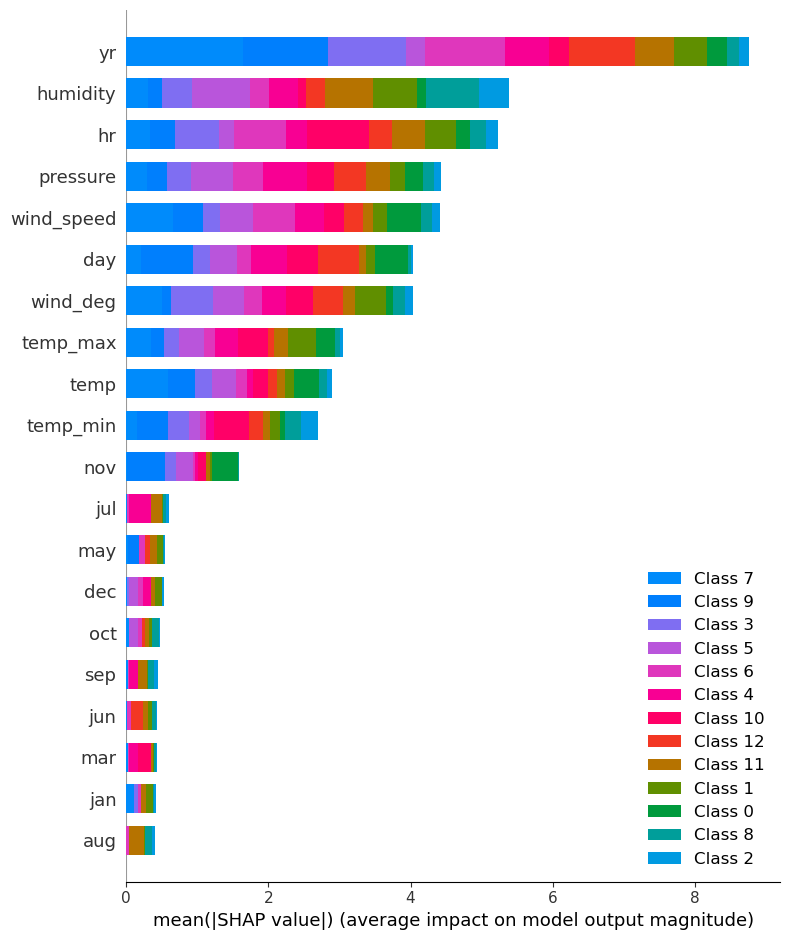

In [43]:
# creating an explainer for our model
explainer_xgb_ohe = shap.TreeExplainer(xgb_clf_ohe) # we only need to pass our  fitted model to tree explainer. 
                                    #No background dataset in 'data' argument required for tree models as it
                                    #is automatically received through the model tree object.

# finding out the shap values using the explainer
shap_values_xgb_ohe = explainer_xgb_ohe.shap_values(X_test_ohe)

# visualize the SHAP for each target
shap.initjs()
shap.summary_plot(shap_values_xgb_ohe, X_test_ohe)

Here we can see that overall for all class, `year` apparently has the biggest contribution to the model output. But for target like `clouds` and `rain`, which are class 2 and class 8, respectively, this feature does not really have much contribution. So that to see how the features affect for dominant class, I will run for summary plot for single class. 

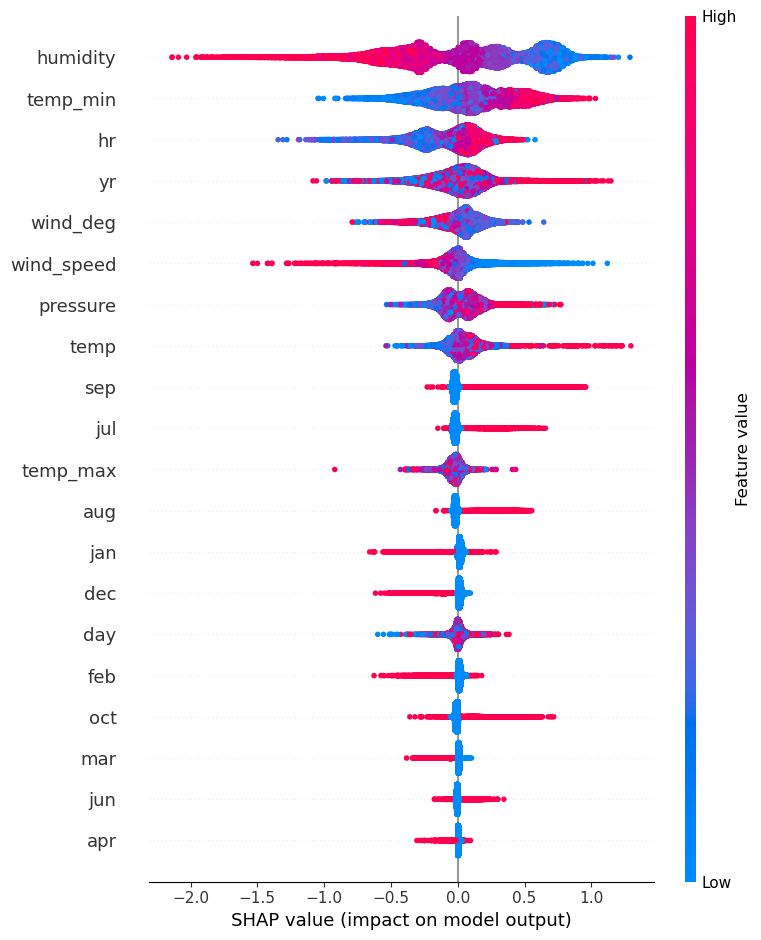

In [33]:
# see individual class for clouds 

shap.initjs()
shap.summary_plot(shap_values_xgb_ohe[2], X_test_ohe)

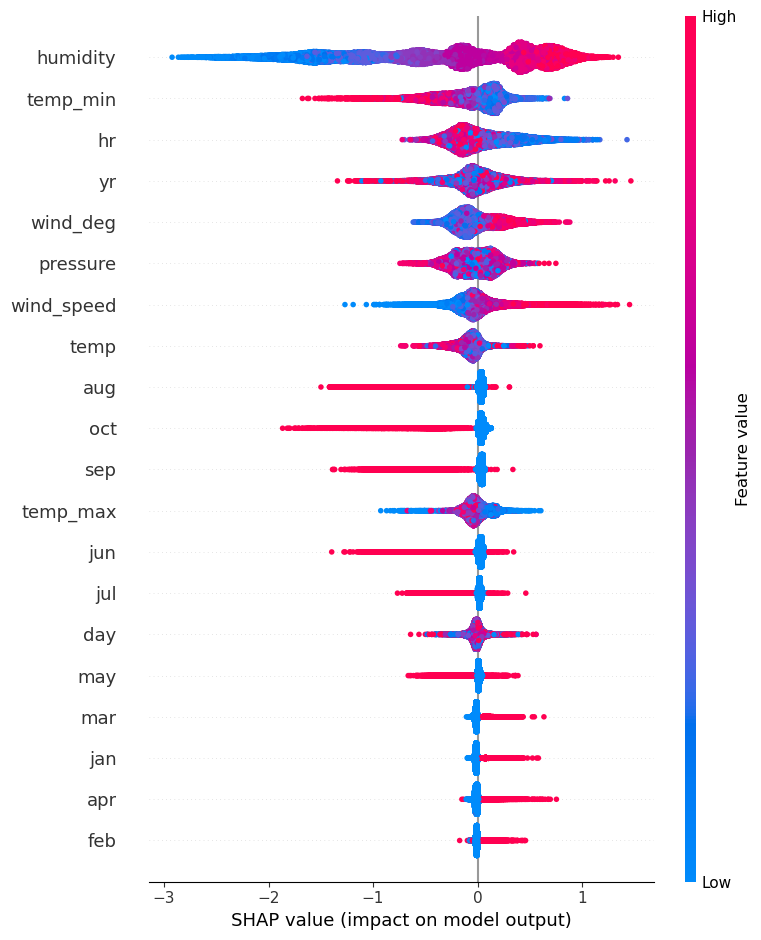

In [34]:
# see individual class for rain

shap.initjs()
shap.summary_plot(shap_values_xgb_ohe[8], X_test_ohe)

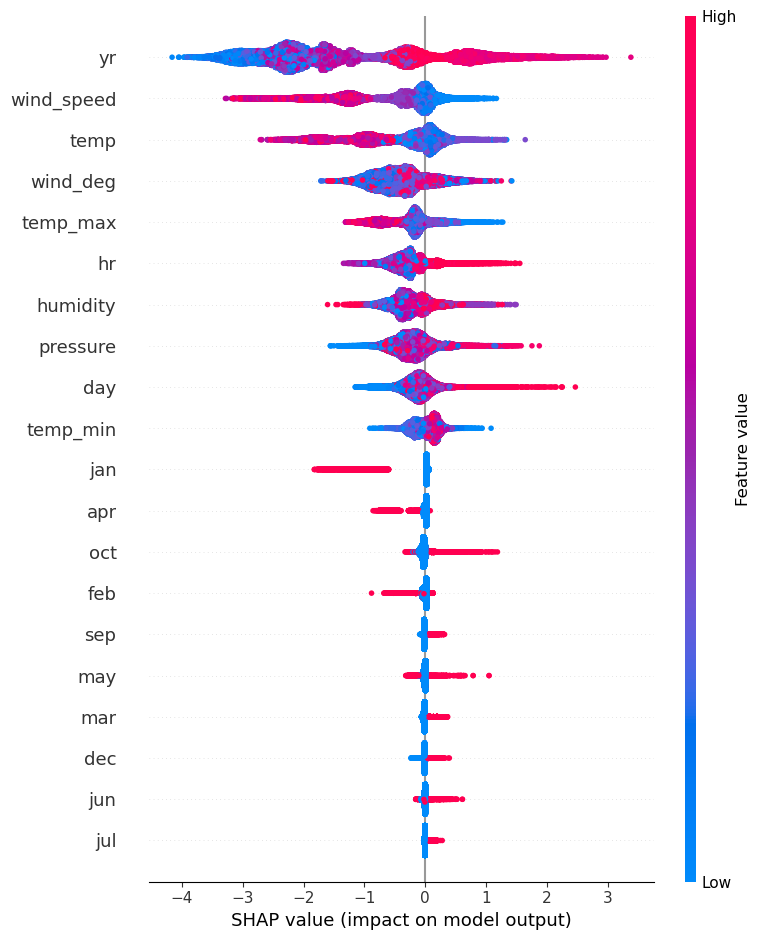

In [35]:
# see individual class for miss

shap.initjs()
shap.summary_plot(shap_values_xgb_ohe[7], X_test_ohe)

From those three example single class, we can see that both dominant target has `humidity` as the most important feature which is logic to be compared with miss that randomly pick `year` as this features actually ordinal number. Yet, something strange looks on class 2 or `clouds` where humidity has inversely proporsional to the occurance prediction , while for class 8 or `rain` humidity acts properly followed the theory. Both of them could be right as relative humidity at surface during cloud weather does not really tell us about the water vapor, while for rain it should be influenced because of the added water (rain). So far this model has a good implication. 

In [36]:
# see the missclassified for applied OHE data

y_pred_xgb_ohe = xgb_clf_ohe.predict(X_test_ohe)
misclassified_xgb_ohe = y_test_ohe!=y_pred_xgb_ohe
sum(misclassified_xgb_ohe)

6574

In [37]:
# see misclassified class for OHE data with XGB Classifier

pred_true_tbl_xgb_ohe = pd.DataFrame({'True':y_test_ohe,'Pred':y_pred_xgb_ohe,'Misclassified':misclassified_xgb_ohe})
display(pred_true_tbl_xgb_ohe[pred_true_tbl_xgb_ohe.Misclassified==True])
print(np.where(pred_true_tbl_xgb_ohe.Misclassified==True))  # Index location of misclassified predictions

,True,Pred,Misclassified
211572,2,8,True
206172,1,2,True
195228,8,2,True
98858,8,2,True
142107,2,8,True
...,...,...,...
210617,8,2,True
134319,8,2,True
2908,1,2,True
54609,8,2,True


(array([    0,    18,    29, ..., 52977, 52981, 52983]),)


As we can see that model mostly missclassification between `rain` and `clouds` also between `clear` and `clouds`. Yet it is understandable as the given feature does not really distinguish them. 

### 3. Random Forest Classifier 

In [44]:
# import module 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestClassifier

In [45]:
# build model use random forest with certain hyperparamter
rf_ohe = RandomForestClassifier(n_estimators=100,random_state=1200)
rf_ohe.fit(X_train_ohe,y_train_ohe)

# see the accuracy
print('Score of RF model on test split with applied OHE:',round(rf_ohe.score(X_test_ohe,y_test_ohe),2))

Score of RF model on test split with applied OHE: 0.89


Text(0, 0.5, 'Mean Decrease in Impurity')

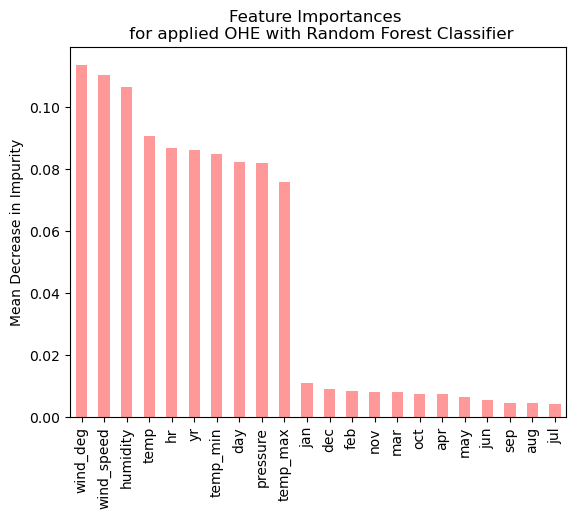

In [46]:
# visualize the feature importance for plain data

feature_importances = pd.Series(rf_ohe.feature_importances_, index=X_train_ohe.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', color='#ff9999', title='Feature Importances \n for applied OHE with Random Forest Classifier')
plt.ylabel('Mean Decrease in Impurity')

In [47]:
# see the multipass permutation importance for XGB Classifier

r_rf_ohe = permutation_importance(rf_ohe, X_test_ohe, y_test_ohe, n_repeats=50,random_state=0)

print('top feature importance for OHE with RF Classifier:')
for i in r_rf_ohe.importances_mean.argsort()[::-1]:
    if r_rf_ohe.importances_mean[i] - 2 * r_rf_ohe.importances_std[i] > 0:
        print(f"{X_test_ohe.columns[i]:<8}"
        f"{r_rf_ohe.importances_mean[i]:.3f}"
        f" +/- {r_rf_ohe.importances_std[i]:.3f}")

top feature importance for OHE with RF Classifier:
humidity0.037 +/- 0.001
hr      0.035 +/- 0.001
wind_deg0.022 +/- 0.001
temp_min0.022 +/- 0.001
yr      0.021 +/- 0.001
wind_speed0.021 +/- 0.001
temp    0.015 +/- 0.001
pressure0.014 +/- 0.000
temp_max0.013 +/- 0.000
day     0.009 +/- 0.000
nov     0.003 +/- 0.000
jan     0.003 +/- 0.000
dec     0.002 +/- 0.000
apr     0.002 +/- 0.000
mar     0.002 +/- 0.000
oct     0.002 +/- 0.000
aug     0.002 +/- 0.000
feb     0.001 +/- 0.000
jun     0.001 +/- 0.000
may     0.001 +/- 0.000
sep     0.001 +/- 0.000
jul     0.001 +/- 0.000


### Conclusions

- The application of feature engineering both label and one-hot encoder not really improved the accuracy
- Every model has different weight of the most importance feature
- The built models have accuracy between 84 - 89%, and the random forest classifier is the best model among them
- SHAP cannot use for GBM Classifier as it requires target with binary number (0 and 1) only and it took very long time to be applied for random forest model
- SHAP, permutation importance, and feature importance helps to understand the way model predict the target, yet SHAP has more features to see the individual class.